In [1]:
# for data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# pandas options
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('mode.use_inf_as_na', True)
pd.options.mode.chained_assignment = None

# for date manipulation
from datetime import datetime

# for visualization: matplotlib
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
# to display visuals in the notebook

# for visualization: plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import iplot

# for visualization: seaborn
import seaborn as sns
sns.set_context(font_scale=2)

# for feature engineering: itertools
from itertools import combinations

# for data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# for building the model and calculate RMSE
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# for hyperparamter optimization and the cross-validation search
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import TimeSeriesSplit

# for model explainability
import shap

# to cleanup memory usage
import gc

import os
from os import path
home = path.abspath(path.join("__file__",".."))
print(home)

from sklearn.metrics import mean_squared_error

# Any results you write to the current directory are saved as output.bb

/Users/anniecondon/Documents/hackathon/climate_change_hackathon.nosync/notebooks


In [2]:
tampa_ferc714_daily_demand = pd.read_csv('tampa_ferc714_daily_demand.csv')

In [3]:
weather_daily = pd.read_csv('tampa_weather_daily_2014-2018.csv')

In [4]:
weather_data_test = pd.read_csv('tampa_weather_daily_2017-2019.csv')

In [5]:
all_florida_weather_daily = pd.read_csv("florida_weather_data_by_county_lat_long.csv")

In [6]:
tampa_ferc714_daily_demand.head()

,utc_datetime,respondent_id_ferc714,demand_mwh
0,2014-01-01,4978,30992.000
1,2014-01-02,6288,42989.000
2,2014-01-03,6288,47059.000
3,2014-01-04,6288,52300.000
4,2014-01-05,6288,42722.000


In [7]:
weather_daily.tail()

,Year,Month,Day,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,date_time
1820,2018,12,27,67.976,72.869,16.999,0.108,4.009,87.714,19.125,1019.800,2018-12-27
1821,2018,12,28,67.517,106.310,20.407,0.108,3.055,95.513,21.180,1017.684,2018-12-28
1822,2018,12,29,55.425,170.006,20.161,0.108,1.369,91.358,21.752,1019.271,2018-12-29
1823,2018,12,30,35.595,267.504,19.824,0.108,1.410,89.514,21.747,1019.088,2018-12-30
1824,2018,12,31,36.626,270.401,18.961,0.108,2.694,89.370,20.905,1018.889,2018-12-31


In [8]:
all_florida_weather_daily.head()

,lat,long,Year,Month,Day,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,date_time
0,24.570,-81.780,2019,1,1,31.417,321.958,21.812,0.030,5.346,82.627,24.967,1019.333,2019-01-01
1,24.570,-81.780,2019,1,2,49.042,214.333,21.817,0.030,5.550,82.561,25.013,1019.500,2019-01-02
2,24.570,-81.780,2019,1,3,36.917,300.500,22.879,0.040,4.237,87.090,25.179,1017.417,2019-01-03
3,24.570,-81.780,2019,1,4,47.750,246.667,22.654,0.040,3.708,86.078,25.154,1016.167,2019-01-04
4,24.570,-81.780,2019,1,5,64.000,162.917,21.529,0.040,3.750,86.019,24.033,1016.583,2019-01-05


In [9]:
tampa_ferc714_daily_demand.utc_datetime = pd.to_datetime(tampa_ferc714_daily_demand.utc_datetime)

In [10]:
weather_daily.date_time = pd.to_datetime(weather_daily.date_time)

In [11]:
all_florida_weather_daily.date_time = pd.to_datetime(all_florida_weather_daily.date_time)

In [12]:
demand_train = tampa_ferc714_daily_demand.loc[tampa_ferc714_daily_demand['utc_datetime'] < '2019-01-01']
print(demand_train.shape)
weather_train = weather_daily.loc[weather_daily['date_time'] < '2019-01-01']
print(weather_train.shape)
demand_test = tampa_ferc714_daily_demand.loc[tampa_ferc714_daily_demand['utc_datetime'] >= '2019-01-01']
print(demand_test.shape)
weather_test = weather_data_test.loc[weather_data_test['date_time'] >= '2019-01-01']
print(weather_test.shape)

(1826, 3)
(1825, 12)
(366, 3)
(365, 12)


In [13]:
demand_train = demand_train.loc[demand_train['utc_datetime']!= '2016-02-29 00:00:00']

In [14]:
demand_train.shape

(1825, 3)

In [15]:
weather_train.loc[weather_train['date_time']== '2016-02-29 00:00:00']

,Year,Month,Day,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,date_time


In [16]:
demand_test = demand_test.loc[demand_test['utc_datetime']!='2020-01-01 00:00:00']
demand_test.shape

(365, 3)

In [17]:
weather_test.to_csv('weather_test.csv', index = False)
demand_test.to_csv('demand_test.csv', index = False)

In [18]:
weather_train.date_time = pd.to_datetime(weather_train.date_time)

# add month, day of week, day of month and hour
weather_train['month'] = weather_train['date_time'].dt.month.astype(np.int8)
weather_train['day_of_week'] = weather_train['date_time'].dt.dayofweek.astype(np.int8)
weather_train['day_of_month']= weather_train['date_time'].dt.day.astype(np.int8)
weather_train['hour'] = weather_train['date_time'].dt.hour

# add is weekend column
weather_train['is_weekend'] = weather_train.day_of_week.apply(lambda x: 1 if x>=5 else 0)

In [19]:
weather_test.date_time = pd.to_datetime(weather_test.date_time)

# add month, day of week, day of month and hour
weather_test['month'] = weather_test['date_time'].dt.month.astype(np.int8)
weather_test['day_of_week'] = weather_test['date_time'].dt.dayofweek.astype(np.int8)
weather_test['day_of_month']= weather_test['date_time'].dt.day.astype(np.int8)
weather_test['hour'] = weather_test['date_time'].dt.hour

# add is weekend column
weather_test['is_weekend'] = weather_test.day_of_week.apply(lambda x: 1 if x>=5 else 0)

In [20]:
#all_florida_weather_daily.date_time = pd.to_datetime(all_florida_weather_daily.date_time)

# add month, day of week, day of month and hour
all_florida_weather_daily['month'] = all_florida_weather_daily['date_time'].dt.month.astype(np.int8)
all_florida_weather_daily['day_of_week'] = all_florida_weather_daily['date_time'].dt.dayofweek.astype(np.int8)
all_florida_weather_daily['day_of_month']= all_florida_weather_daily['date_time'].dt.day.astype(np.int8)
all_florida_weather_daily['hour'] = all_florida_weather_daily['date_time'].dt.hour

# add is weekend column
all_florida_weather_daily['is_weekend'] = all_florida_weather_daily.day_of_week.apply(lambda x: 1 if x>=5 else 0)

In [21]:
def convert_season(month):
    if (month <= 2) | (month == 12):
        return 0
    # as winter
    elif month <= 5:
        return 1
    # as spring
    elif month <= 8:
        return 2
    # as summer
    elif month <= 11:
        return 3
    # as fall

In [22]:
weather_train['season'] = weather_train.month.apply(convert_season)

In [23]:
weather_test['season'] = weather_test.month.apply(convert_season)

In [24]:
all_florida_weather_daily['season'] = all_florida_weather_daily.month.apply(convert_season)

Check for missing.

In [25]:
weather_train.isna().sum()

Year                 0
Month                0
Day                  0
DHI                  0
DNI                  0
Dew Point            0
Surface Albedo       0
Wind Speed           0
Relative Humidity    0
Temperature          0
Pressure             0
date_time            0
month                0
day_of_week          0
day_of_month         0
hour                 0
is_weekend           0
season               0
dtype: int64

In [26]:
weather_test.isna().sum()

Year                 0
Month                0
Day                  0
DHI                  0
DNI                  0
Dew Point            0
Surface Albedo       0
Wind Speed           0
Relative Humidity    0
Temperature          0
Pressure             0
date_time            0
month                0
day_of_week          0
day_of_month         0
hour                 0
is_weekend           0
season               0
dtype: int64

In [27]:
all_florida_weather_daily.isna().sum()

lat                  0
long                 0
Year                 0
Month                0
Day                  0
DHI                  0
DNI                  0
Dew Point            0
Surface Albedo       0
Wind Speed           0
Relative Humidity    0
Temperature          0
Pressure             0
date_time            0
month                0
day_of_week          0
day_of_month         0
hour                 0
is_weekend           0
season               0
dtype: int64

In [28]:
demand_train.isna().sum()

utc_datetime             0
respondent_id_ferc714    0
demand_mwh               0
dtype: int64

In [29]:
demand_train.isna().sum()

utc_datetime             0
respondent_id_ferc714    0
demand_mwh               0
dtype: int64

In [30]:
demand_test.dtypes

utc_datetime             datetime64[ns]
respondent_id_ferc714             int64
demand_mwh                      float64
dtype: object

In [31]:
weather_train.date_time = pd.to_datetime(weather_train.date_time)

In [32]:
demand_train.utc_datetime = pd.to_datetime(demand_train.utc_datetime)

In [33]:
demand_test.utc_datetime = pd.to_datetime(demand_test.utc_datetime)

#### Transform Temperature and Dew Point

In [34]:
weather_train['temperature_2'] = weather_train['Temperature']**2
weather_train['temperature_3'] = weather_train['Temperature']**3
weather_train['dew_point_2'] = weather_train['Dew Point']**2
weather_train['dew_point_3'] = weather_train['Dew Point']**3
weather_test['temperature_2'] = weather_test['Temperature']**2
weather_test['temperature_3'] = weather_test['Temperature']**3
weather_test['dew_point_2'] = weather_test['Dew Point']**2
weather_test['dew_point_3'] = weather_test['Dew Point']**3
all_florida_weather_daily['temperature_3'] = all_florida_weather_daily['Temperature']**3
all_florida_weather_daily['dew_point_3'] = all_florida_weather_daily['Dew Point']**3

In [35]:
train = (demand_train.merge(weather_train, 
                                  left_on='utc_datetime',
                                  right_on= 'date_time',
                                  how='left'))

In [36]:
test = (demand_test.merge(weather_test, 
                                  left_on='utc_datetime',
                                  right_on= 'date_time',
                                  how='left'))

In [37]:
test = test.loc[~test.Temperature.isna()]

In [38]:
print("Number of unique columns in the train dataset:", train.shape[1])

Number of unique columns in the train dataset: 25


In [39]:
print("Number of unique columns in the test dataset:", test.shape[1])

Number of unique columns in the test dataset: 25


#### Check correlations of weather and seasonal inputs with demand data.

In [40]:
correlations_transformed = pd.DataFrame(train.corr())
correlations_transformed = pd.DataFrame(correlations_transformed["demand_mwh"]).reset_index()

# format, and display sorted correlations_transformed
correlations_transformed.columns = ["Feature", "Correlation with meter_reading"]
corr_df = (correlations_transformed[correlations_transformed["Feature"] != "meter_reading"]
                .sort_values(by="Correlation with meter_reading", ascending=True))
corr_df

,Feature,Correlation with meter_reading
9,Wind Speed,-0.363
12,Pressure,-0.204
17,is_weekend,-0.157
14,day_of_week,-0.106
15,day_of_month,0.018
4,Day,0.018
6,DNI,0.031
0,respondent_id_ferc714,0.063
10,Relative Humidity,0.113
2,Year,0.123


#### Get list of variables with a absolute correlation of greater than 0.20

In [41]:
initial_feature_list = (corr_df[
    (corr_df["Correlation with meter_reading"] >= 0.20) | 
    (corr_df["Correlation with meter_reading"] <= -0.20)]["Feature"].
                        to_list())

In [42]:
initial_feature_list.remove('demand_mwh')
initial_feature_list.remove('dew_point_2')
initial_feature_list.remove('temperature_2')
initial_feature_list.remove('Dew Point')
initial_feature_list.remove('Temperature')
# initial_feature_list.remove('log_dew_point')
# initial_feature_list.remove('log_temperature')
#initial_feature_list.remove('Month')

In [43]:
initial_feature_list

['Wind Speed',
 'Pressure',
 'season',
 'DHI',
 'Surface Albedo',
 'dew_point_3',
 'temperature_3']

In [44]:
train.head()

,utc_datetime,respondent_id_ferc714,demand_mwh,Year,Month,Day,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,date_time,month,day_of_week,day_of_month,hour,is_weekend,season,temperature_2,temperature_3,dew_point_2,dew_point_3
0,2014-01-01,4978,30992.000,2014,1,1,33.821,3.479,14.730,0.107,3.339,87.795,17.396,1017.163,2014-01-01,1,2,1,0,0,0,302.638,5264.841,216.978,3196.114
1,2014-01-02,6288,42989.000,2014,1,2,61.916,79.469,18.635,0.107,3.539,95.755,19.658,1009.593,2014-01-02,1,3,2,0,0,0,386.440,7596.658,347.273,6471.512
2,2014-01-03,6288,47059.000,2014,1,3,38.559,250.445,5.317,0.107,5.912,71.567,10.786,1015.066,2014-01-03,1,4,3,0,0,0,116.346,1254.951,28.272,150.325
3,2014-01-04,6288,52300.000,2014,1,4,57.479,30.674,7.463,0.107,3.292,80.124,11.475,1017.110,2014-01-04,1,5,4,0,1,0,131.673,1510.926,55.701,415.711
4,2014-01-05,6288,42722.000,2014,1,5,35.460,267.702,15.885,0.107,2.060,88.521,18.438,1010.579,2014-01-05,1,6,5,0,1,0,339.966,6268.344,252.341,4008.504


#### Scatter plots of input variable relationships with demand to check if the list of correlated variables makes sense

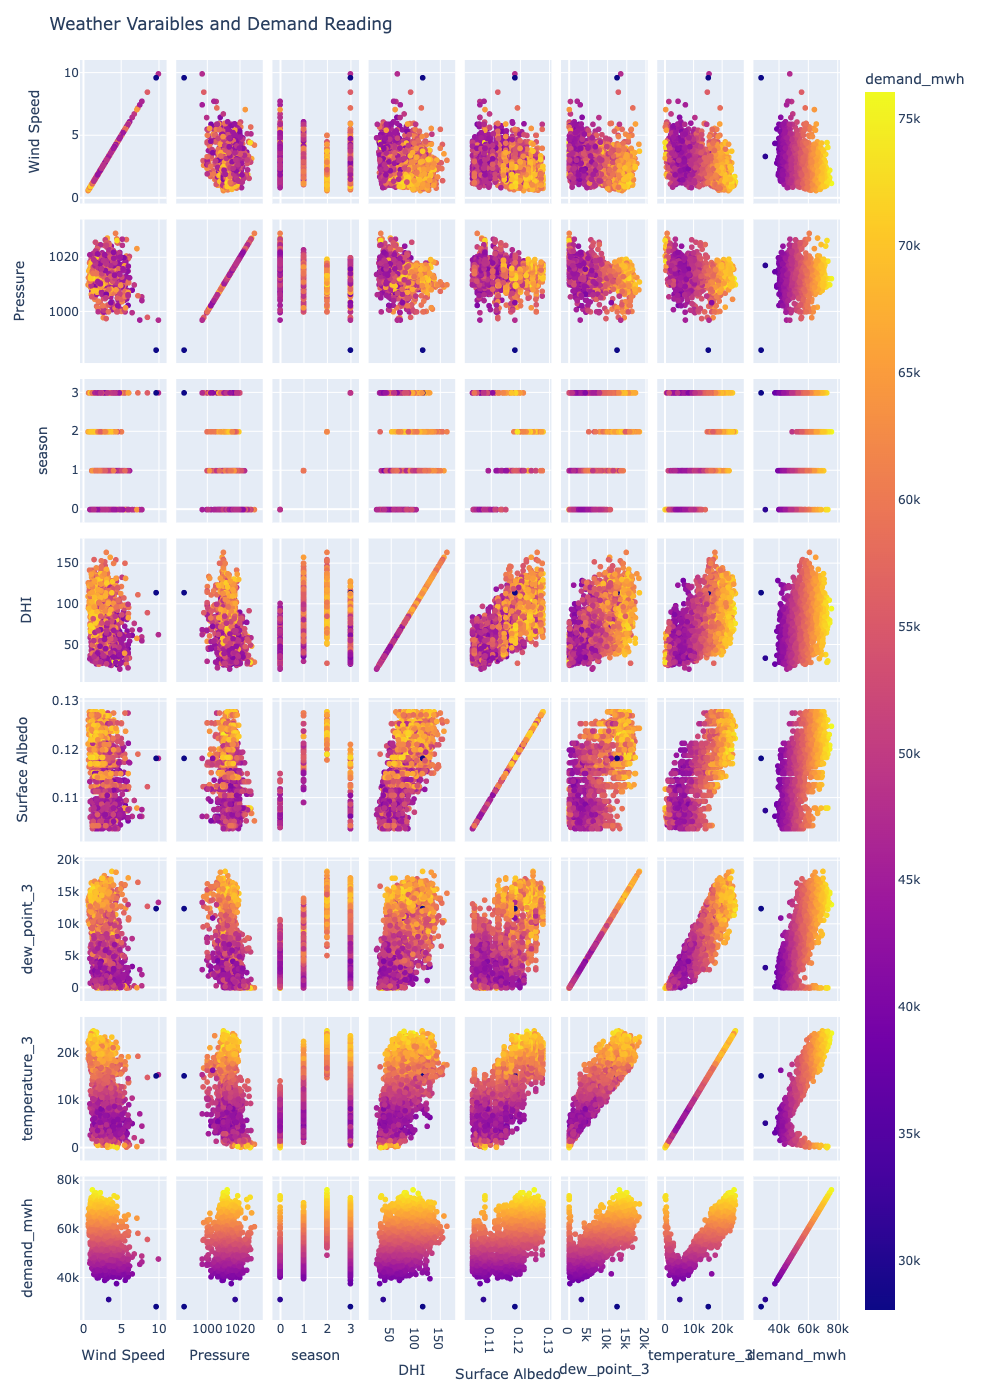

In [45]:
fig = px.scatter_matrix(train,
                        dimensions=['Wind Speed',
                                    'Pressure',
                                    'season',
                                    'DHI',
                                    'Surface Albedo',
                                    'dew_point_3',
                                    'temperature_3',
                                    'demand_mwh'],
                        color="demand_mwh")

fig.update_layout(
    title='Weather Varaibles and Demand Reading',
    dragmode='select',
    width=1400,
    height=1400,
    hovermode='closest')

fig.update_traces(diagonal_visible=True)
fig.show()

#### Separate data sets into input and output data

In [46]:
X = train[initial_feature_list]
y = train['demand_mwh']

In [47]:
X_test = test[initial_feature_list]
y_test = test['demand_mwh']

In [48]:
all_florida_weather_daily = all_florida_weather_daily.set_index("date_time")
sub_all_florida_weather_daily = all_florida_weather_daily[initial_feature_list]

In [49]:
sub_all_florida_weather_daily.head()


,Wind Speed,Pressure,season,DHI,Surface Albedo,dew_point_3,temperature_3
date_time,,,,,,,
2019-01-01,5.346,1019.333,0,31.417,0.030,10378.064,15562.583
2019-01-02,5.550,1019.500,0,49.042,0.030,10384.012,15648.449
2019-01-03,4.237,1017.417,0,36.917,0.040,11976.243,15963.351
2019-01-04,3.708,1016.167,0,47.750,0.040,11626.374,15915.849
2019-01-05,3.750,1016.583,0,64.000,0.040,9978.877,13881.680


In [50]:
test.head()

,utc_datetime,respondent_id_ferc714,demand_mwh,Year,Month,Day,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,date_time,month,day_of_week,day_of_month,hour,is_weekend,season,temperature_2,temperature_3,dew_point_2,dew_point_3
0,2019-01-01,6288,46163.000,2019,1,1,36.670,270.158,18.782,0.106,1.326,89.841,20.641,1019.815,2019-01-01,1,1,1,0,0,0,426.044,8793.896,352.746,6625.117
1,2019-01-02,6288,47702.000,2019,1,2,38.237,240.246,18.313,0.106,1.339,85.024,21.162,1018.988,2019-01-02,1,2,2,0,0,0,447.849,9477.578,335.357,6141.316
2,2019-01-03,6288,48768.000,2019,1,3,71.979,103.204,19.729,0.106,1.676,92.686,21.038,1016.439,2019-01-03,1,3,3,0,0,0,442.613,9311.854,389.235,7679.246
3,2019-01-04,6288,49177.000,2019,1,4,60.477,79.937,19.555,0.106,3.841,93.610,20.684,1013.522,2019-01-04,1,4,4,0,0,0,427.813,8848.744,382.416,7478.331
4,2019-01-05,6288,41180.000,2019,1,5,41.023,243.240,13.165,0.106,4.235,83.104,16.093,1016.329,2019-01-05,1,5,5,0,1,0,258.999,4168.175,173.320,2281.775


In [51]:
y_test.head()

0   46163.000
1   47702.000
2   48768.000
3   49177.000
4   41180.000
Name: demand_mwh, dtype: float64

In [52]:
#X_test = X_test.loc[~X_test.Temperature.isna()]

In [53]:
#y_test = y_test.loc[~y_test.isna()]

In [54]:
print("Pearson coefficient based feature selection leaves us with {} features.".
      format(len(X.columns)))

Pearson coefficient based feature selection leaves us with 7 features.


#### Standardize data

In [55]:
from sklearn.preprocessing import StandardScaler
#data = [[0, 0], [0, 0], [1, 1], [1, 1]]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)
sub_all_florida_weather_daily = scaler.fit_transform(sub_all_florida_weather_daily)

#### Create validation set for cross-validation

In [56]:
# split train and validation set into 75 and 25 percent sequentially
X_train = X[:int(3 * X.shape[0] / 4)]
X_valid = X[int(3 * X.shape[0] / 4):]

y_train = y[:int(3 * y.shape[0] / 4)]
y_valid = y[int(3 * y.shape[0] / 4):]

In [57]:
# make sure train and validation sets shape align
print("Shape of the training set is: ", X_train.shape)
print("Shape of the validation set is: ", X_valid.shape)
print("Shape of the test set is: ", X_test.shape)
print("Shape of the training labels are: ", y_train.shape)
print("Shape of the validation labels are: ", y_valid.shape)
print("Shape of the test labels are: ", y_test.shape)

Shape of the training set is:  (1368, 7)
Shape of the validation set is:  (457, 7)
Shape of the test set is:  (365, 7)
Shape of the training labels are:  (1368,)
Shape of the validation labels are:  (457,)
Shape of the test labels are:  (365,)


In [58]:
def rmse(y_true, y_pred):
    return np.sqrt(
        np.mean(
            np.square(y_true - y_pred)
        )
    )

In [59]:
def mse(y_true, y_pred):
    return np.mean(
            np.square(y_true - y_pred)
        )

In [60]:
def mean_abs_error(y_true, y_pred):
    return np.mean(
            np.abs(y_true - y_pred)
        )

In [61]:
y_valid

1368   59552.000
1369   61134.000
1370   58796.000
1371   58814.000
1372   57035.000
          ...   
1820   44636.000
1821   48899.000
1822   48836.000
1823   48138.000
1824   48550.000
Name: demand_mwh, Length: 457, dtype: float64

In [62]:
from sklearn.metrics import mean_absolute_error as mae
baseline_guess = np.median(y_train)
print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the valid set: RMSE = %0.4f" % rmse(y_valid, baseline_guess))
print("Baseline Performance on the valid set: MSE = %0.4f" % mse(y_valid, baseline_guess))
print("Baseline Performance on the valid set: MAE = %0.4f" % mean_abs_error(y_valid, baseline_guess))

The baseline guess is a score of 54590.50
Baseline Performance on the valid set: RMSE = 9077.1731
Baseline Performance on the valid set: MSE = 82395072.2806
Baseline Performance on the valid set: MAE = 7870.9551


In [63]:
print("Min value of demand (mwh) is:", y.min())
print("Median value of demand (mwh) is:", y.median())
print("Max value of demand (mwh) is:", y.max())

Min value of demand (mwh) is: 28074.0
Median value of demand (mwh) is: 54460.0
Max value of demand (mwh) is: 76048.0


In [65]:
#X_test.isna().sum()

In [66]:
y_test.isna().sum()

0

In [67]:
def fit_evaluate_model_rmse(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    #print(y_predicted.shape)
    #print(y_valid.shape)
    return sqrt(mean_squared_error(y_valid, y_predicted))

In [68]:
def fit_evaluate_model_mse(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    #print(y_predicted.shape)
    #print(y_valid.shape)
    return mean_squared_error(y_valid, y_predicted)

In [69]:
def fit_evaluate_model_mae(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    #print(y_predicted.shape)
    #print(y_valid.shape)
    return mae(y_valid, y_predicted)

In [70]:
def test_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    #print(y_test_predicted.shape)
    #print(y_test.shape)
    #return sqrt(mean_squared_error(y_test, y_test_predicted))
    return y_test_predicted

In [71]:
def score_other_data(model,X_train, y_train, new_data):
    model.fit(X_train, y_train)
    new_data_predicted = model.predict(new_data)
    print(new_data_predicted.shape)
    return new_data_predicted

In [72]:
%%time
# create model apply fit_evaluate_model
linear_regression = LinearRegression()
lr_rmse = fit_evaluate_model_rmse(linear_regression, X_train, y_train, X_valid, y_valid)
lr_mse = fit_evaluate_model_mse(linear_regression, X_train, y_train, X_valid, y_valid)
lr_mae = fit_evaluate_model_mae(linear_regression, X_train, y_train, X_valid, y_valid)
y_test_predicted = test_evaluate_model(linear_regression, X_train, y_train, X_test, y_test)
new_data_predicted = score_other_data(linear_regression, X_train, y_train, sub_all_florida_weather_daily)
print("RMSE of the linear regression model is:", lr_rmse)
print("MSE of the linear regression model is:", lr_mse)
print("MAE of the linear regression model is:", lr_mae)
#print("RMSE of the linear regression model on test data is:", y_test_predicted)

(23360,)
RMSE of the linear regression model is: 5126.206610936307
MSE of the linear regression model is: 26277994.218007095
MAE of the linear regression model is: 3481.8698231803023
CPU times: user 77.8 ms, sys: 15.8 ms, total: 93.5 ms
Wall time: 51 ms


### Merge predictions on test data with test actual outcomes

In [73]:
y_test_predicted = pd.DataFrame(y_test_predicted)
y_test_predicted = y_test_predicted.rename(columns = {0:'lr_pred_demand_mwh'})
y_test_predicted = pd.concat([y_test_predicted, test.utc_datetime], axis = 1)
display(y_test_predicted.head())
print(y_test.shape)
print(y_test_predicted.shape)
y_test_predicted_x_actual = pd.concat([y_test_predicted, y_test], axis = 1)

,lr_pred_demand_mwh,utc_datetime
0,51965.555,2019-01-01
1,52093.213,2019-01-02
2,50195.578,2019-01-03
3,48819.451,2019-01-04
4,44352.981,2019-01-05


(365,)
(365, 2)


In [74]:
print(y_test_predicted_x_actual)

     lr_pred_demand_mwh utc_datetime  demand_mwh
0             51965.555   2019-01-01   46163.000
1             52093.213   2019-01-02   47702.000
2             50195.578   2019-01-03   48768.000
3             48819.451   2019-01-04   49177.000
4             44352.981   2019-01-05   41180.000
..                  ...          ...         ...
360           51225.964   2019-12-27   45841.000
361           52020.870   2019-12-28   46087.000
362           51922.761   2019-12-29   48421.000
363           50637.900   2019-12-30   49408.000
364           44984.014   2019-12-31   44659.000

[365 rows x 3 columns]


#### Plot actual vs. predicted demand for Tampa Electric Co in 2019 using linear regression

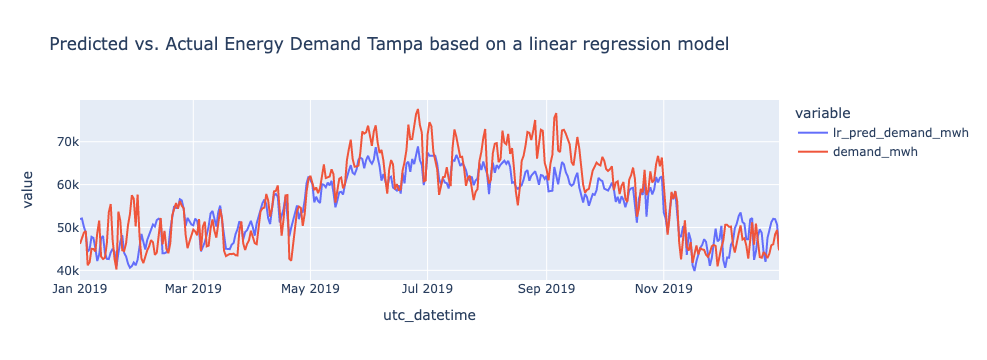

In [75]:
# plot the time series
fig = px.line(y_test_predicted_x_actual, x="utc_datetime", y=["lr_pred_demand_mwh", "demand_mwh"],
    title="Predicted vs. Actual Energy Demand Tampa based on a linear regression model", width=1000)
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
fig.show()


In [76]:
y_test_predicted.to_csv('y_test_predicted.csv', index=False)

In [77]:
y_test_predicted_x_actual.to_csv('y_test_predicted_x_actual_lr.csv', index = False)

#### Reset Florida Weather data and zip predictions to data frame

In [78]:
all_florida_weather_daily = all_florida_weather_daily.reset_index()
all_florida_weather_data_demand_predicted = pd.DataFrame(new_data_predicted)
display(all_florida_weather_data_demand_predicted.head())
all_florida_weather_data_demand_predicted = all_florida_weather_data_demand_predicted.rename(columns = {0:'pred_demand_mwh'})
all_florida_weather_data_demand_predicted = pd.concat([all_florida_weather_data_demand_predicted, all_florida_weather_daily], axis = 1)
all_florida_weather_data_demand_predicted.to_csv('all_florida_weather_data_demand_predicted.csv', index = False)

,0
0,58438.773
1,57908.085
2,58851.990
3,57990.930
4,55172.603


In [225]:
X.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [74]:
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [89]:
y_test = y_test.to_numpy()
y_test = np.around(y_test, decimals=4, out=None)

In [97]:
print(predictions.dtype)

float32


#### Train XgBoost Model

In [79]:
#Importing Packages
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#from sklearn.preprocessing import Imputer

In [80]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [81]:
#Run only in the first run of the kernel.
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [82]:
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.1,
        max_depth = 5,
        min_child_weight = 3,
        n_estimators = 100,
        subsample = 0.7)

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)

y_pred_xgb = xgb_model.predict(X_valid)

mae_xgb = mean_absolute_error(y_valid, y_pred_xgb)
mse_xgb = mean_squared_error(y_valid, y_pred_xgb)

print("MAE: ", mae_xgb)
print("MSE: ", mse_xgb)

CPU times: user 1.19 s, sys: 35.5 ms, total: 1.23 s
Wall time: 179 ms
MAE:  2432.4248153719914
MSE:  9822022.503901308


#### Create predictions on test set

In [83]:
# Use the model to make predictions
y_pred_test = xgb_model.predict(X_test)

In [84]:
y_test_predicted = pd.DataFrame(y_pred_test)
y_test_predicted = y_test_predicted.rename(columns = {0:'xg_pred_demand_mwh'})
y_test_predicted = pd.concat([y_test_predicted, test.utc_datetime], axis = 1)
display(y_test_predicted.head())
print(y_test.shape)
print(y_test_predicted.shape)
y_test_predicted_x_actual_xgboost = pd.concat([y_test_predicted, y_test], axis = 1)

,xg_pred_demand_mwh,utc_datetime
0,45324.738,2019-01-01
1,46151.902,2019-01-02
2,46510.000,2019-01-03
3,46485.590,2019-01-04
4,43541.539,2019-01-05


(365,)
(365, 2)


In [241]:
#y_test_predicted_x_actual_xgboost = y_test_predicted_x_actual_xgboost.rename(columns = {'lr_pred_demand_mwh':'xg_pred_demand_mwh'})

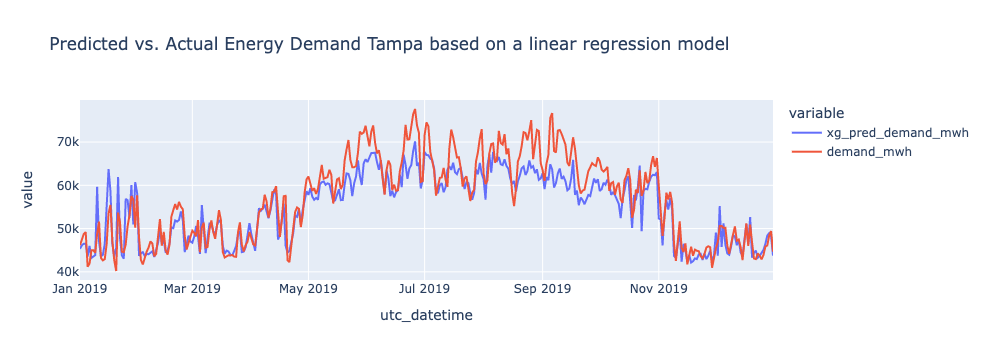

In [85]:
# plot the time series
fig = px.line(y_test_predicted_x_actual_xgboost, x="utc_datetime", y=["xg_pred_demand_mwh", "demand_mwh"],
    title="Predicted vs. Actual Energy Demand Tampa based on a linear regression model", width=1000)
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
fig.show()

#### Create Xgboost Predictions on All Florida data

In [86]:
# Use the model to make predictions
new_data_predicted = xgb_model.predict(sub_all_florida_weather_daily)

In [88]:
#all_florida_weather_daily = all_florida_weather_daily.reset_index()
all_florida_weather_data_demand_predicted = pd.DataFrame(new_data_predicted)
display(all_florida_weather_data_demand_predicted.head())
all_florida_weather_data_demand_predicted = all_florida_weather_data_demand_predicted.rename(columns = {0:'pred_demand_mwh_tampa'})
all_florida_weather_data_demand_predicted = pd.concat([all_florida_weather_data_demand_predicted, all_florida_weather_daily], axis = 1)
all_florida_weather_data_demand_predicted.to_csv('all_florida_weather_data_demand_predicted_xgboost.csv', index = False)

,0
0,54583.922
1,53470.586
2,57685.520
3,58263.832
4,55025.652


In [89]:
display(all_florida_weather_data_demand_predicted.head())

,pred_demand_mwh_tampa,date_time,lat,long,Year,Month,Day,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,month,day_of_week,day_of_month,hour,is_weekend,season,temperature_3,dew_point_3
0,54583.922,2019-01-01,24.570,-81.780,2019,1,1,31.417,321.958,21.812,0.030,5.346,82.627,24.967,1019.333,1,1,1,0,0,0,15562.583,10378.064
1,53470.586,2019-01-02,24.570,-81.780,2019,1,2,49.042,214.333,21.817,0.030,5.550,82.561,25.013,1019.500,1,2,2,0,0,0,15648.449,10384.012
2,57685.520,2019-01-03,24.570,-81.780,2019,1,3,36.917,300.500,22.879,0.040,4.237,87.090,25.179,1017.417,1,3,3,0,0,0,15963.351,11976.243
3,58263.832,2019-01-04,24.570,-81.780,2019,1,4,47.750,246.667,22.654,0.040,3.708,86.078,25.154,1016.167,1,4,4,0,0,0,15915.849,11626.374
4,55025.652,2019-01-05,24.570,-81.780,2019,1,5,64.000,162.917,21.529,0.040,3.750,86.019,24.033,1016.583,1,5,5,0,1,0,13881.680,9978.877
